In [ ]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.cm as mpl_cm
import pandas as pd
import cv2  
from os import listdir 
from os.path import isfile, join 
import os 
from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler,PolynomialFeatures 
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.pipeline import Pipeline 
import random 
from defisheye import Defisheye
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.svm import LinearSVC 
import joblib 



def display_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    labels = sorted(list(set(y_true))) 
    ConfusionMatrixDisplay(cm,display_labels=labels).plot()


class  ImagePreprocessing():
    """
    A Custom class to preform preprocessings. 

    This transformer takes an iterable of images (e.g., a list or a NumPy array)
    and resizes each image to a target size using OpenCV's cv2.resize function.

    The input `X` is expected to be a collection where each element
    is a valid image represented as a NumPy array.

    Attributes:
        height (int): The target height for the resized images.
        width (int): The target width for the resized images.
        
    """
    def __init__(self, height=64, width=64):
        self.height = height
        self.width = width


    def resize(self, X):
        """
        Resizes each image in the input iterable.
        and flatens them to a 1d representation: 
        an unflattened version maybe obtained by using the method unflaten 

        Args:
            X (iterable): The input data, expected to be an iterable of images.
                          Each element should be a NumPy array representing an image.

        Returns:
            np.ndarray: A new NumPy array containing a flattend representation of the resized images.
        """
        if not hasattr(X, '__iter__'):
            raise TypeError("Input must be an iterable (e.g., a list or NumPy array).")
        
        resized_images = []
        for i, image in enumerate(X):
            # Check if the individual item is a valid image (a NumPy array)
            if not isinstance(image, np.ndarray) or image.ndim not in [2, 3]:
                raise ValueError(f"Element at index {i} is not a valid image (expected 2D or 3D NumPy array), got {type(image)}.")

            try:
                # Resize the image using OpenCV
                resized_image = cv2.resize(image, (self.width, self.height), interpolation=cv2.INTER_CUBIC)
                resized_images.append(resized_image)
            except Exception as e:
                # This handles potential errors from cv2.resize for malformed arrays
                raise RuntimeError(f"Could not resize image at index {i}. Original shape: {image.shape}. Error: {e}")

        # It's a good practice for transformers to return a NumPy array
        # as a standard output type for subsequent steps in a pipeline.
        return np.array(resized_images)

    def flatten(self, X ): 
        flattend_images = []
        for i, image in enumerate(X):
            flattend_images.append(image.flatten())
        return np.array(flattend_images)

    def add_edgeimage(self,X): 
        if not hasattr(X, '__iter__'):
            raise TypeError("Input must be an iterable (e.g., a list or NumPy array).")
        
        rgb_gray_images = []
        for i, image in enumerate(X):
            # Check if the individual item is a valid image (a NumPy array)
            if not isinstance(image, np.ndarray) or image.ndim not in [ 3]:
                raise ValueError(f"Element at index {i} is not a valid image (expected 2D or 3D NumPy array), got {type(image)}.")

            try:
                # Resize the image using OpenCV
                grey_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) #(mxn)
                # Apply Sobel operator
                sobelx = cv2.Sobel(grey_image, cv2.CV_64F, 1, 0, ksize=3)  # Horizontal edges
                sobely = cv2.Sobel(grey_image, cv2.CV_64F, 0, 1, ksize=3)  # Vertical edges
 
                # Compute gradient magnitude
                gradient_magnitude = cv2.magnitude(sobelx, sobely)
 
                # Convert to uint8
                gradient_magnitude = cv2.convertScaleAbs(gradient_magnitude)# 
                gradient_magnitude=gradient_magnitude.reshape(gradient_magnitude.shape+(1,))#(mxnx1)
                im_rgb_Edge= np.concat((image,gradient_magnitude),axis=2)#(mxnx3)+(mxnx1)=(mxnx4) (rgb gray)
                rgb_gray_images.append(im_rgb_Edge)
            except Exception as e:
                # This handles potential errors from cv2.resize for malformed arrays
                raise RuntimeError(f"Could not resize image at index {i}. Original shape: {image.shape}. Error: {e}")
        return rgb_gray_images
    
    def add_rotation_copies(self,X,y):
        augmented_images=[] 
        augmented_labels=[]
        for i, image in enumerate(X):
            height, width = image.shape[:2]
 
            # Define the rotation center
            center = (width // 2, height // 2)
 
            # Define the rotation angle
            angles = [90,180,270]  # Rotate by 45 degrees
 
            # Define the scaling factor 
            scale = 1.0  # No scaling
            augmented_images.append(image)
            augmented_labels.append(y[i])
            for angle in angles:
                # Get the rotation matrix
                rotation_matrix = cv2.getRotationMatrix2D(center, angle, scale)
 
                # Perform the rotation
                rotated_image = cv2.warpAffine(image, rotation_matrix, (width, height))
                augmented_images.append(rotated_image)
                augmented_labels.append(y[i])
        return augmented_images,np.array(augmented_labels)


## Load in images

In [43]:
dirpath="./CCSN_v2"
class_dirs=listdir(dirpath)
lists_image_names=[]
for dir in class_dirs: 
    lists_image_names.append(listdir(dirpath+"/"+dir))


images= []
y=[] 
for  i in range(len(class_dirs)): 
    for image_name in lists_image_names[i]: 
        im=cv2.imread( dirpath+"/"+class_dirs[i]+"/"+image_name )
        im= cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        images.append(im)
        y.append(class_dirs[i])

labels=np.array(y)


# Preprocess images & data division 

In [ ]:
n=64 #determined in from trails in slask 

imResizer=ImagePreprocessing(height=n, width=n)   
images_rgb_gray= imResizer.add_edgeimage(images)
resized_images= imResizer.resize(images_rgb_gray)
augmented_resized_images,augmented_y =imResizer.add_rotation_copies(resized_images,labels)
images_training_data= imResizer.flatten(augmented_resized_images)

X=images_training_data
y=augmented_y

X_train_val, X_test, y_train_val , y_test =train_test_split(X,y ,test_size=0.1 ,random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train_val,y_train_val, test_size=0.2, random_state=42)




# Train model + cross validation 

In [ ]:
n_comp=10 #determined from trails in slask 

pipeline_steps = {
    "logreg": [('scaler', StandardScaler()),
    ('pca', PCA(n_components=n_comp, random_state=21)),
    ('poly', PolynomialFeatures(2)),
    ('logreg',LogisticRegression(random_state=42))],
    "RF": [('scaler', StandardScaler()),
    ('pca', PCA(n_components=n_comp, random_state=21)),
    ('poly', PolynomialFeatures(2)),
    ('RF-CLF',RandomForestClassifier(random_state=42))],
    "ET": [('scaler', StandardScaler()),
    ('pca', PCA(n_components=n_comp, random_state=21)),
    ('poly', PolynomialFeatures(2)),
    ('ET-CLF',RandomForestClassifier(random_state=42))],
}



models = {
    # 'LogisticRegression': {
    #     'model': Pipeline(steps=pipeline_steps['logreg'] ) ,
    #     'params': {
    #         'logreg__C': [0.01, 0.1, 1, 10, 100],
    #         'logreg__penalty': ['l1', 'l2'],
    #         'logreg__solver': ['saga'], 
    #         'logreg__max_iter': [100] 
    #     }
    # },
    'RandomForestClassifier': {
        'model':Pipeline(steps=pipeline_steps['RF'] ),
        'params': {
            'RF-CLF__n_estimators': [100, 200, 300],
            'RF-CLF__max_depth': [ 10, 20, 30]
        }
    },
    'ExtraTreesClassifier': {
        'model': Pipeline(steps=pipeline_steps['ET'] ),
        'params': {
            'ET-CLF__n_estimators': [100, 200, 300],
            'ET-CLF__max_depth': [ 10, 20, 30]
        }
    },
}

best_models = {}
best_parameters={}

for name, config in models.items():
    print(f"Training {name} with GridSearchCV...")
    grid_search = GridSearchCV(
        estimator=config['model'],
        param_grid=config['params'],
        cv=5,  # Use 5-fold cross-validation
        scoring='accuracy',
        n_jobs=-1 # Use all available cores
    )
    
    # Train on the training set
    grid_search.fit(X_train, y_train)
    
    print(f"Best parameters for {name}: {grid_search.best_params_}")
    print(f"Best cross-validation score for {name}: {grid_search.best_score_:.4f}")
    
    # Store the best model
    best_models[name] = grid_search.best_estimator_
    best_parameters[name] = grid_search.best_params_
    print("-" * 50)




Training RandomForestClassifier with GridSearchCV...
Best parameters for RandomForestClassifier: {'RF-CLF__max_depth': 30, 'RF-CLF__n_estimators': 300}
Best cross-validation score for RandomForestClassifier: 0.4200
--------------------------------------------------
Training ExtraTreesClassifier with GridSearchCV...
Best parameters for ExtraTreesClassifier: {'ET-CLF__max_depth': 30, 'ET-CLF__n_estimators': 300}
Best cross-validation score for ExtraTreesClassifier: 0.4200
--------------------------------------------------


              precision    recall  f1-score   support

          Ac       0.53      0.26      0.35       150
          As       0.53      0.37      0.44       127
          Cb       0.45      0.61      0.52       167
          Cc       0.46      0.66      0.54       201
          Ci       0.36      0.14      0.21        90
          Cs       0.44      0.31      0.36       227
          Ct       0.61      0.79      0.69       153
          Cu       0.47      0.23      0.31       124
          Ns       0.43      0.48      0.46       207
          Sc       0.40      0.78      0.53       223
          St       0.24      0.05      0.08       162

    accuracy                           0.46      1831
   macro avg       0.45      0.43      0.41      1831
weighted avg       0.45      0.46      0.42      1831



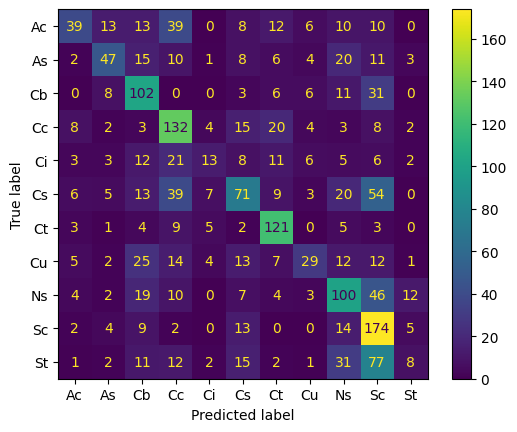

In [ ]:
prefix = 'ET-CLF__'
choosen_parameters={}
for key, value in best_parameters['ExtraTreesClassifier'].items():
    if key.startswith(prefix):
        new_key = key.replace(prefix, '')
        choosen_parameters[new_key] = value




ET_pipeline_train= Pipeline(steps=[('StandardScaler',StandardScaler()), ('PCA', PCA(n_components=n_comp, random_state=21)),('ET-CLF',ExtraTreesClassifier(**choosen_parameters,random_state=21) ) ]) 
ET_pipeline_train.fit(X_train, y_train) 
y_pred_val= ET_pipeline_train.predict(X_val)
display_confusion_matrix(y_val, y_pred_val) 


print(classification_report(y_val, y_pred_val))



              precision    recall  f1-score   support

          Ac       0.70      0.37      0.48       104
          As       0.53      0.41      0.46        71
          Cb       0.57      0.80      0.66       102
          Cc       0.52      0.66      0.58       122
          Ci       0.57      0.25      0.35        63
          Cs       0.36      0.31      0.33        94
          Ct       0.62      0.79      0.70        81
          Cu       0.54      0.29      0.38        66
          Ns       0.52      0.59      0.55       105
          Sc       0.47      0.72      0.57       132
          St       0.33      0.18      0.23        78

    accuracy                           0.52      1018
   macro avg       0.52      0.49      0.48      1018
weighted avg       0.52      0.52      0.50      1018



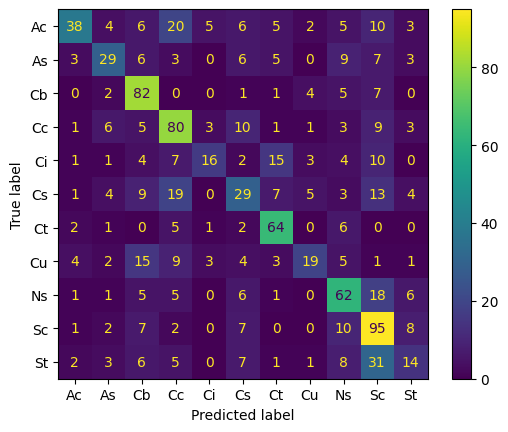

In [47]:

ET_pipeline_train_val= Pipeline(steps=[('StandardScaler',StandardScaler()), ('PCA', PCA(n_components=n_comp, random_state=21)),('ET-CLF',ExtraTreesClassifier(**choosen_parameters,random_state=21) ) ]) 

ET_pipeline_train_val.fit(X_train_val, y_train_val) 

y_pred_test= ET_pipeline_train_val.predict(X_test)

display_confusion_matrix(y_test, y_pred_test) 
print(classification_report(y_test, y_pred_test))



In [48]:
ET_model= Pipeline(steps=[('StandardScaler',StandardScaler()), ('PCA', PCA(n_components=n_comp, random_state=21)),('ET-CLF',ExtraTreesClassifier(**choosen_parameters,random_state=21) ) ]) 

ET_model.fit(X, y) 

joblib.dump(ET_model, f"Cloud_predictor_{n}_ncomp_{n_comp}.pkl")

['Cloud_predictor_32_ncomp_25.pkl']